# Results for single settings

This notebook displays the results for each of the single settings introduced in the paper (same as done in section 6.1)

In [1]:
import json
import re
from analysis import Analysis, guesser_vs_oracle_update, stepwise_guesser_annotations
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from collections import defaultdict 
from IPython.display import HTML
import ipywidgets as widgets
from IPython.display import display
import nltk

plt.rcParams.update({'font.size': 13})
sns.set_style("darkgrid")

## Load data

Select one setting from the following:

* **8_mcrae** *(8 candidates based on McRae feature norms)*

* **16_mcrae** *(16 candidates based on McRae feature norms)*

* **8_gpt** *(8 candidates based on ChatGPT's feature norms)*

* **8_wordnet** *(8 candidates based on WordNet taxonomy)*

* **8_mcrae_stepwise** *(8 candidates based on McRae feature norms + Modified Prompt for explicit HypSpace update)*

In [33]:
setting = "8_mcrae"

backends = [
    "chatgpt",
    "gemini",
    "qwen",
    "llama"
]

Processing chatgpt...
Processing gemini...
Processing qwen...
Processing llama...
   Backend  Average Questions  Optimal  Baseline
0  chatgpt               5.48      3.5       4.0
1   gemini               5.93      3.5       4.0
2     qwen               9.78      3.5       4.0
3    llama               8.77      3.5       4.0


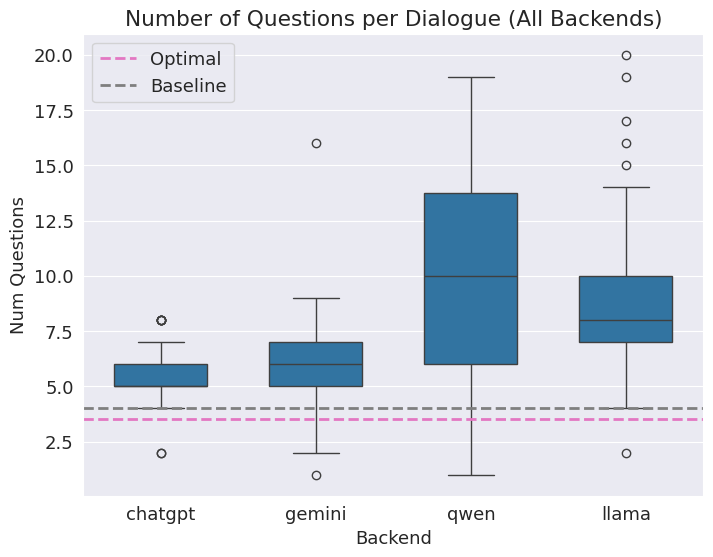

In [34]:
all_questions = []
summary_rows = []

for backend in backends:

    print(f"Processing {backend}...")

    with open(f"../data/generation/{backend}/{setting}/dialogues.txt") as f:
        dialogues = f.read()

    with open(f"../data/generation/{backend}/{setting}/oracle_annotations.json") as f:
        oracle_annotations = json.load(f)

    analysis = Analysis(dialogues, oracle_annotations, setting)

    avg_qs = analysis.average_questions()

    # Summary table row
    summary_rows.append({
        "Backend": backend,
        "Average Questions": round(avg_qs, 2)
    })

    # Store full distribution for boxplot
    for q in analysis.questions_dist:
        all_questions.append({
            "Backend": backend,
            "Num Questions": q
        })


# =========================
# Summary table
# =========================

summary_df = pd.DataFrame(summary_rows)

summary_df["Optimal"] = np.log2(analysis.num_candidates) + 0.5
summary_df["Baseline"] = analysis.num_candidates / 2

print(summary_df)


# =========================
# Boxplot
# =========================

plot_df = pd.DataFrame(all_questions)

plt.figure(figsize=(8,6))

sns.boxplot(
    data=plot_df,
    x="Backend",
    y="Num Questions",
    width=0.6
)

plt.axhline(
    np.log2(analysis.num_candidates)+0.5,
    color='tab:pink',
    linestyle='--',
    linewidth=2,
    label='Optimal'
)

plt.axhline(
    analysis.num_candidates/2,
    color='tab:gray',
    linestyle='--',
    linewidth=2,
    label='Baseline'
)

plt.title("Number of Questions per Dialogue (All Backends)")
plt.ylabel("Num Questions")
plt.legend()

plt.show()

In [5]:
print(stats.wilcoxon(np.array(analysis.questions_dist) - (analysis.num_candidates/2)))

WilcoxonResult(statistic=np.float64(10.5), pvalue=np.float64(4.578358501758907e-16))


##### Unnecessary questions

In [35]:
results = []

for backend in backends:

    print(f"Processing {backend}...")

    with open(f"../data/generation/{backend}/{setting}/dialogues.txt") as f:
        dialogues = f.read()

    with open(f"../data/generation/{backend}/{setting}/oracle_annotations.json") as f:
        oracle_annotations = json.load(f)

    analysis = Analysis(dialogues, oracle_annotations, setting)

    unnecessary_qs, percentage_unnecessary_dial, percentage_unnecessary_qs = \
        analysis.unnecessary_questions()

    total_uq = np.sum(unnecessary_qs)

    results.append({
        "Backend": backend,
        "Total UQ": int(total_uq),
        "% Games with ≥1 UQ": round(percentage_unnecessary_dial, 2),
        "% UQ among all questions": round(percentage_unnecessary_qs, 2)
    })


df = pd.DataFrame(results)

print(df)

Processing chatgpt...
Processing gemini...
Processing qwen...
Processing llama...
   Backend  Total UQ  % Games with ≥1 UQ  % UQ among all questions
0  chatgpt        68               46.67                     13.79
1   gemini        89               50.00                     16.67
2     qwen       338               63.33                     38.41
3    llama       310               77.78                     39.29


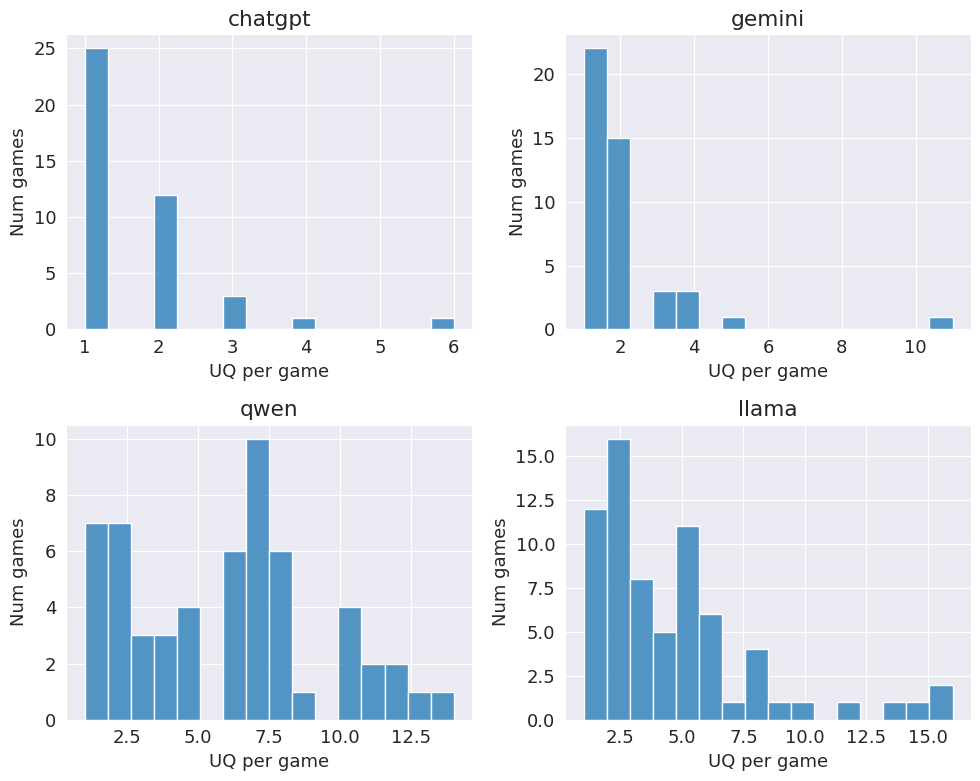

In [37]:
backends = ["chatgpt", "gemini", "qwen","llama"]
setting = "8_mcrae"

fig, axes = plt.subplots(2, 2, figsize=(10,8))

for ax, backend in zip(axes.flatten(), backends):

    with open(f"../data/generation/{backend}/{setting}/dialogues.txt") as f:
        dialogues = f.read()

    with open(f"../data/generation/{backend}/{setting}/oracle_annotations.json") as f:
        annotations = json.load(f)

    analysis = Analysis(dialogues, annotations, setting)

    unnecessary_qs, _, _ = analysis.unnecessary_questions()

    sns.histplot(unnecessary_qs, bins=16, ax=ax)

    ax.set_title(backend)
    ax.set_xlabel("UQ per game")
    ax.set_ylabel("Num games")

plt.tight_layout()
plt.show()


## Information-Seeking Strategy

### Type of questions

In [38]:
import pandas as pd
import numpy as np
import json

backends = ["chatgpt", "gemini", "qwen", "llama"]
setting = "8_mcrae"

rows = []

for backend in backends:

    with open(f"../data/generation/{backend}/{setting}/dialogues.txt") as f:
        dialogues = f.read()

    with open(f"../data/generation/{backend}/{setting}/oracle_annotations.json") as f:
        annotations = json.load(f)

    analysis = Analysis(dialogues, annotations, setting)

    hypothesis_scanning, constraint_seeking, pseudo_constraint_seeking = analysis.questions_strategies()

    hs = hypothesis_scanning + pseudo_constraint_seeking
    cs = constraint_seeking

    rows.append({
        "Backend": backend,
        "HS (%)": round(hs, 2),
        "CS (%)": round(cs, 2),
    })


# convert to dataframe
df = pd.DataFrame(rows)


# add Optimal and Baseline
num_candidates = analysis.num_candidates

df["Optimal HS (%)"] = round(
    1.5/(np.log2(num_candidates)+0.5)*100, 2
)

df["Optimal CS (%)"] = round(
    (np.log2(num_candidates)-1)/(np.log2(num_candidates)+0.5)*100, 2
)

df["Baseline HS (%)"] = 100.0
df["Baseline CS (%)"] = 0.0


display(df)


,Backend,HS (%),CS (%),Optimal HS (%),Optimal CS (%),Baseline HS (%),Baseline CS (%)
0,chatgpt,31.85,68.15,42.86,57.14,100.0,0.0
1,gemini,28.46,71.54,42.86,57.14,100.0,0.0
2,qwen,24.77,75.23,42.86,57.14,100.0,0.0
3,llama,24.71,75.29,42.86,57.14,100.0,0.0


In [39]:
import pandas as pd
import numpy as np
import json
from IPython.display import HTML

# modify here
setting = "8_mcrae"
backends = ["chatgpt", "gemini", "qwen", "llama"]

all_tables = []

for backend in backends:

    # load data
    with open(f"../data/generation/{backend}/{setting}/dialogues.txt") as f:
        dialogues = f.read()

    with open(f"../data/generation/{backend}/{setting}/oracle_annotations.json") as f:
        oracle_annotations = json.load(f)

    # run analysis
    analysis = Analysis(dialogues, oracle_annotations, setting)

    hypothesis_scanning, constraint_seeking, pseudo_constraint_seeking = analysis.questions_strategies()

    num_candidates = analysis.num_candidates

    # build dataframe for this backend
    df = pd.DataFrame(
        {
            "Backend": backend,
            "Type": ["HS", "CS", "PCS"],
            "Model": [
                round(hypothesis_scanning, 2),
                round(constraint_seeking, 2),
                round(pseudo_constraint_seeking, 2)
            ],
            "Optimal": [
                round(1.5/(np.log2(num_candidates)+0.5)*100, 2),
                round((np.log2(num_candidates)-1)/(np.log2(num_candidates)+0.5)*100, 2),
                0.0
            ],
            "Baseline": [
                100.0,
                0.0,
                0.0
            ]
        }
    )

    all_tables.append(df)

# merge all
final_df = pd.concat(all_tables, ignore_index=True)

# show table
HTML(final_df.to_html(index=False))


Backend,Type,Model,Optimal,Baseline
chatgpt,HS,23.33,42.86,100.0
chatgpt,CS,68.15,57.14,0.0
chatgpt,PCS,8.52,0.00,0.0
gemini,HS,17.79,42.86,100.0
gemini,CS,71.54,57.14,0.0
gemini,PCS,10.67,0.00,0.0
qwen,HS,11.59,42.86,100.0
qwen,CS,75.23,57.14,0.0
qwen,PCS,13.18,0.00,0.0
llama,HS,15.08,42.86,100.0


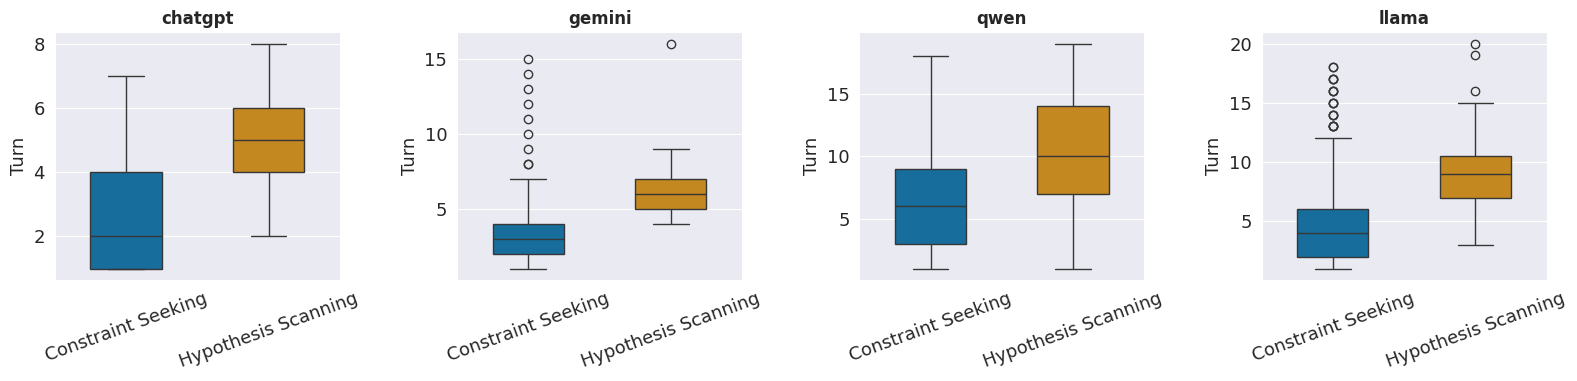

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))

setting = "8_mcrae"
backends = ["chatgpt", "gemini", "qwen", "llama"]

colors = sns.color_palette("colorblind", 2)

for i, backend in enumerate(backends):

    with open(f"../data/generation/{backend}/{setting}/dialogues.txt") as f:
        dialogues = f.read()

    with open(f"../data/generation/{backend}/{setting}/oracle_annotations.json") as f:
        annotations = json.load(f)

    analysis = Analysis(dialogues, annotations, setting)

    analysis.questions_strategies()

    sns.boxplot(
        [analysis.cs_questions_pos, analysis.hs_questions_pos],
        palette=colors,
        width=0.5,
        ax=axes[i]
    )

    axes[i].set_title(backend, fontsize=12, fontweight="bold")
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(["Constraint Seeking", "Hypothesis Scanning"], rotation=20)

    axes[i].set_ylabel("Turn")

plt.tight_layout()
plt.show()


In [50]:
print(stats.mannwhitneyu(analysis.hs_questions_pos, analysis.cs_questions_pos))

MannwhitneyuResult(statistic=42645.0, pvalue=5.399384105091375e-19)


There is a significant difference between the position of HS and CS questions.

### EIG per turn

In [41]:
import pandas as pd
import numpy as np
import json

setting = "8_mcrae"
backends = ["chatgpt", "gemini", "qwen","llama"]

all_rows = []

for backend in backends:

    with open(f"../data/generation/{backend}/{setting}/dialogues.txt") as f:
        dialogues = f.read()

    with open(f"../data/generation/{backend}/{setting}/oracle_annotations.json") as f:
        oracle_annotations = json.load(f)

    analysis = Analysis(dialogues, oracle_annotations, setting)

    avg_qs = analysis.average_questions()

    ig_per_turn = analysis.compute_eig()

    max_turn = round(avg_qs)

    for i in range(max_turn):

        row = {
            "Backend": backend,
            "Turn": i+1,
            "Model": round(np.mean(ig_per_turn["model"][i]), 2),
            "Optimal": round(np.mean(ig_per_turn["optimal"][i]), 2),
            "Baseline": round(np.mean(ig_per_turn["baseline"][i]), 2)
        }

        all_rows.append(row)


df = pd.DataFrame(all_rows)

HTML(df.to_html(index=False))


Backend,Turn,Model,Optimal,Baseline
chatgpt,1,0.91,1.00,0.54
chatgpt,2,0.50,0.96,0.76
chatgpt,3,0.61,0.84,0.74
chatgpt,4,0.43,0.60,0.59
chatgpt,5,0.28,0.40,0.40
gemini,1,0.91,1.00,0.54
gemini,2,0.58,0.99,0.79
gemini,3,0.51,0.85,0.77
gemini,4,0.40,0.65,0.62
gemini,5,0.34,0.53,0.52


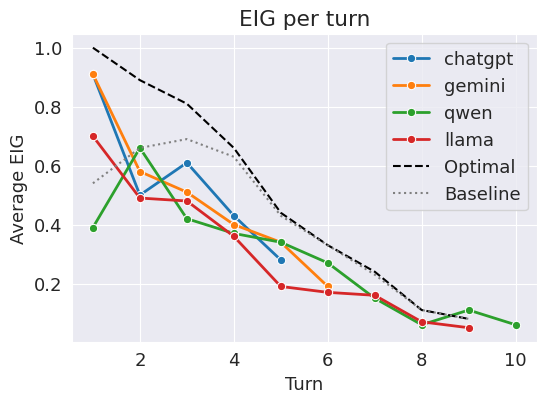

In [42]:
setting = "8_mcrae"
backends = ["chatgpt", "gemini","qwen", "llama"]

plt.figure(figsize=(6,4))

for backend in backends:

    with open(f"../data/generation/{backend}/{setting}/dialogues.txt") as f:
        dialogues = f.read()

    with open(f"../data/generation/{backend}/{setting}/oracle_annotations.json") as f:
        oracle_annotations = json.load(f)

    analysis = Analysis(dialogues, oracle_annotations, setting)

    avg_qs = analysis.average_questions()

    ig_per_turn = analysis.compute_eig()

    eig_dict = {
        i : round(np.mean(ig_per_turn["model"][i]),2)
        for i in range(round(avg_qs))
    }

    df = pd.DataFrame.from_dict(eig_dict, orient='index')

    df.index = range(1,(round(avg_qs)+1))

    sns.lineplot(
        data=df[0],
        marker="o",
        linewidth=2,
        label=backend
    )


# plot optimal and baseline only once
num_candidates = analysis.num_candidates

optimal = [
    round(np.mean(ig_per_turn["optimal"][i]),2)
    for i in range(round(avg_qs))
]

baseline = [
    round(np.mean(ig_per_turn["baseline"][i]),2)
    for i in range(round(avg_qs))
]

plt.plot(range(1,round(avg_qs)+1), optimal,
         linestyle="--", color="black", label="Optimal")

plt.plot(range(1,round(avg_qs)+1), baseline,
         linestyle=":", color="gray", label="Baseline")


plt.title("EIG per turn")
plt.xlabel("Turn")
plt.ylabel("Average EIG")

plt.legend()

plt.show()


## Hypothesis Space update

In [53]:
correcteness, distance = guesser_vs_oracle_update(guesser_annotations, oracle_annotations)

df = pd.DataFrame(
    {
        "Turn" : range(1,(round(avg_qs)+1)), 
        "HypSpace Update Distance" : [np.mean(distance[i]) for i in range(1,(round(avg_qs)+1))]
    }
)

HTML(df.to_html(index=False))

Turn,HypSpace Update Distance
1,0.466667
2,1.188889
3,1.125000
4,1.693333
5,1.774194
6,1.595745
7,1.793103


## Error analysis

* ER = Error rate
* SP = % games with spoiler answers by oracle
* CQ = % contradictory questions across all games
* TQ = % trivial questions across all games

In [43]:
setting = "8_mcrae"
backends = ["chatgpt", "gemini","qwen","llama"]

rows = []

for backend in backends:

    with open(f"../data/generation/{backend}/{setting}/dialogues.txt") as f:
        dialogues = f.read()

    with open(f"../data/generation/{backend}/{setting}/oracle_annotations.json") as f:
        oracle_annotations = json.load(f)

    analysis = Analysis(dialogues, oracle_annotations, setting)

    row = {
        "Backend": backend,
        "ER": round(analysis.ans_error_rate(), 2),
        "SP": round(analysis.oracle_spoilers(), 2),
        "CQ": round(analysis.contradictory_questions(), 2),
        "TQ": round(analysis.trivial_questions(), 2)
    }

    rows.append(row)


df = pd.DataFrame(rows)

HTML(df.to_html(index=False))


Backend,ER,SP,CQ,TQ
chatgpt,6.67,0.00,3.85,25.15
gemini,8.89,1.11,5.62,28.46
qwen,33.33,6.67,17.16,35.23
llama,3.33,0.00,13.69,37.90
